In [34]:
import torch
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [35]:
data_dim = 16
# Define the parameters for the three Gaussian distributions
mean1, cov1 = np.zeros(data_dim), np.eye(data_dim)  # Mean 0, Identity covariance
mean2, cov2 = np.ones(data_dim), np.eye(data_dim) * 2  # Mean 1, Covariance with larger variance
mean3, cov3 = np.arange(data_dim), np.eye(data_dim) * 4  # Linearly increasing mean, smaller variance

# Sample 334 points from the first two Gaussians and 332 from the third to make a total of 1000 samples
samples1 = np.random.multivariate_normal(mean1, cov1, 900)
labels1 = np.zeros(900)
samples2 = np.random.multivariate_normal(mean2, cov2, 900)
labels2 = np.ones(900) 
samples3 = np.random.multivariate_normal(mean3, cov3, 900)
labels3 = np.ones(900) * 2
# Combine the samples into one dataset
all_embeds = np.concatenate([samples1, samples2, samples3])
gt_labels = np.concatenate([labels1, labels2, labels3])
# Check the shape to confirm
print(all_embeds.shape)
print(gt_labels.shape)

(2700, 16)
(2700,)


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2700 samples in 0.001s...
[t-SNE] Computed neighbors for 2700 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2700
[t-SNE] Computed conditional probabilities for sample 2000 / 2700
[t-SNE] Computed conditional probabilities for sample 2700 / 2700
[t-SNE] Mean sigma: 2.166524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.698273
[t-SNE] KL divergence after 1000 iterations: 1.810364


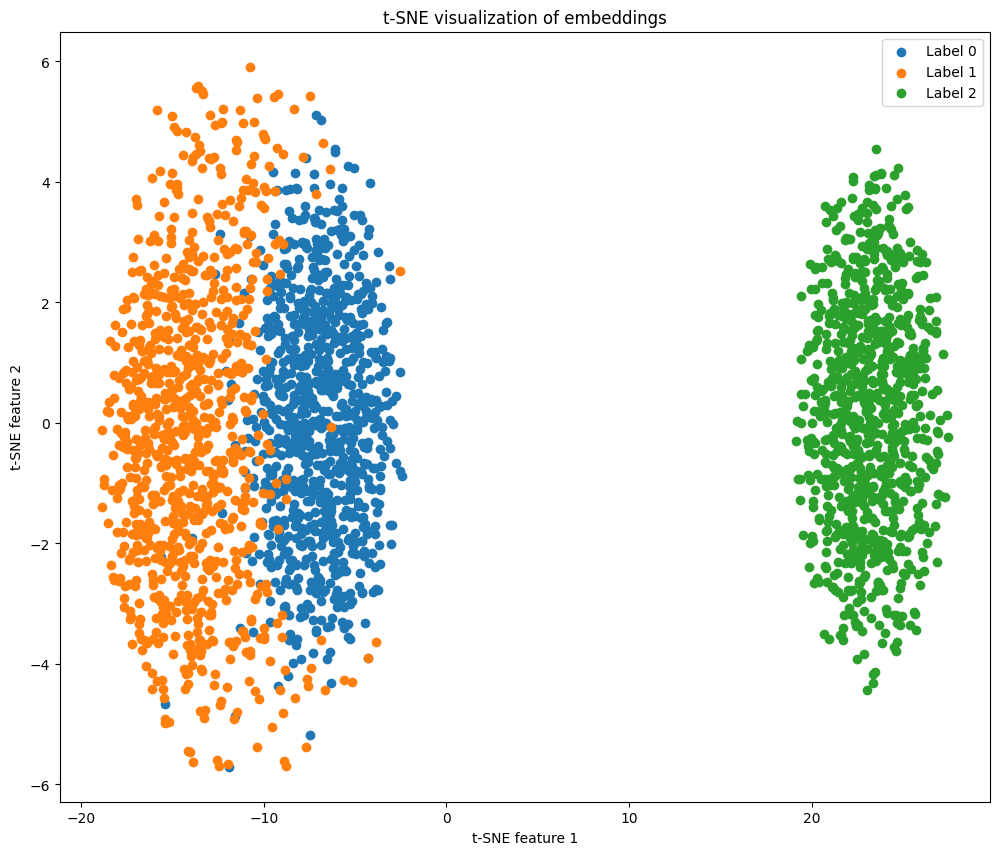

In [36]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(all_embeds)
# Plotting
plt.figure(figsize=(12, 10))

# Scatter plot of the reduced data, color by label
for i in range(len(np.unique(gt_labels))):  # Assuming your labels are 0-indexed categories
    plt.scatter(tsne_results[gt_labels == i, 0], tsne_results[gt_labels == i, 1], label=f'Label {i}')

plt.legend()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of embeddings')
plt.show()

In [37]:
scaler = MinMaxScaler()
normalized_all_embeds = scaler.fit_transform(all_embeds)
training_seq = torch.FloatTensor(normalized_all_embeds[:,None,:])
print(training_seq.shape)
dataset = Dataset1D(training_seq) 

torch.Size([2700, 1, 16])


In [38]:
model = Unet1D(
    dim = 8,
    dim_mults = (1, 2, 4, 8),
    channels = 1
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = data_dim,
    timesteps = 1000,
    objective = 'pred_v'
)

In [39]:
trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 64,
    train_lr = 8e-5,
    train_num_steps = 1000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)

In [40]:
trainer.train()

loss: 0.1836: 100%|██████████| 1000/1000 [03:32<00:00,  4.70it/s]

training complete


In [41]:
sampled_seq = diffusion.sample(batch_size = 512)
print(sampled_seq.shape)

sampling loop time step: 100%|██████████| 1000/1000 [00:12<00:00, 82.32it/s]

torch.Size([512, 1, 16])


In [42]:
generated_embeds = sampled_seq.detach().cpu().numpy()[:,0,:]
generated_embeds = scaler.inverse_transform(generated_embeds)
print(generated_embeds.shape)
generated_lables = np.zeros(generated_embeds.shape[0]) - 1
print(generated_lables.shape)

combined_embeds = np.concatenate((all_embeds, generated_embeds), axis=0)
print(combined_embeds.shape)
combined_labels = np.concatenate((gt_labels, generated_lables), axis=0)
print(combined_labels.shape)

(512, 16)
(512,)
(3212, 16)
(3212,)


In [43]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(combined_embeds)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 3212 samples in 0.001s...
[t-SNE] Computed neighbors for 3212 samples in 0.231s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3212
[t-SNE] Computed conditional probabilities for sample 2000 / 3212
[t-SNE] Computed conditional probabilities for sample 3000 / 3212
[t-SNE] Computed conditional probabilities for sample 3212 / 3212
[t-SNE] Mean sigma: 2.205138
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.600647
[t-SNE] KL divergence after 1000 iterations: 1.857405


(2700, 2)
(512, 2)


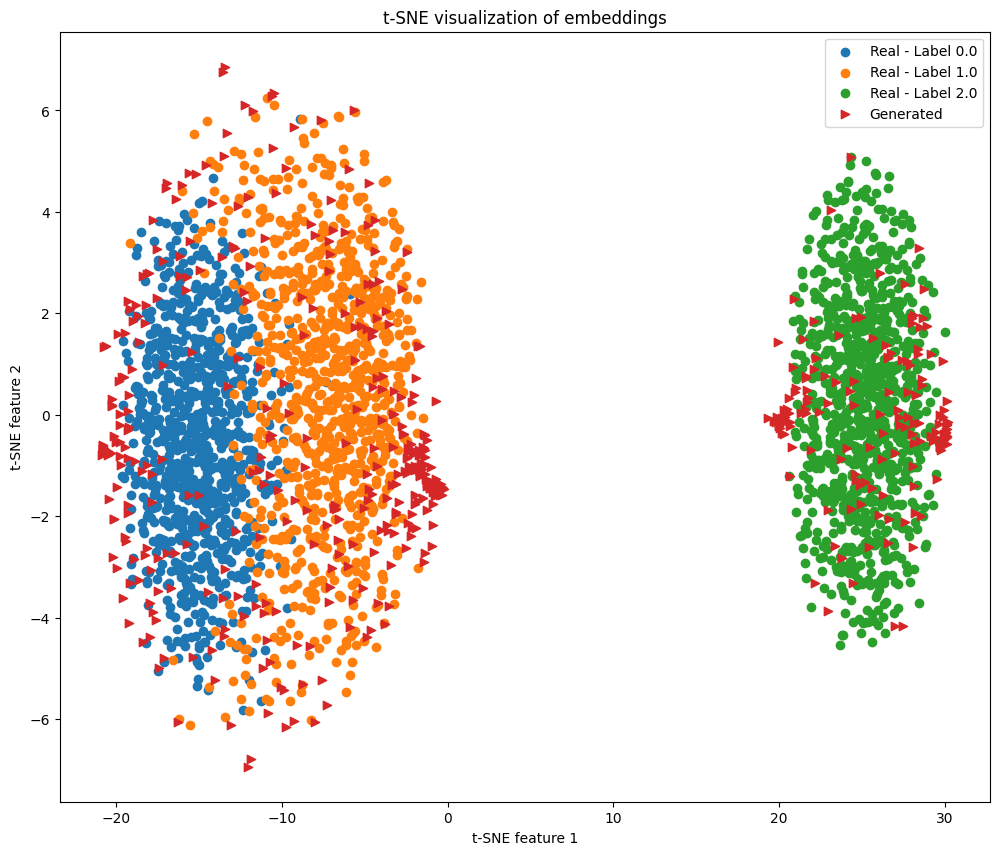

In [44]:
# Plotting
plt.figure(figsize=(12, 10))

n_real = all_embeds.shape[0]

tsne_results_real = tsne_results[:n_real]
print(tsne_results_real.shape)
tsne_results_generated = tsne_results[n_real:]
print(tsne_results_generated.shape)

unique_labels = np.unique(gt_labels)  # Get all unique labels from both sets

for i in unique_labels:  # Iterate through each unique label
    # Plot real data
    plt.scatter(tsne_results_real[gt_labels == i, 0], tsne_results_real[gt_labels == i, 1],  label=f'Real - Label {i}')
    
# Plot generated data
plt.scatter(tsne_results_generated[:, 0], tsne_results_generated[:, 1], label=f'Generated', marker='>')

plt.legend()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of embeddings')
plt.show()